# Final Project - Work Plan + Model Training And Testing + Report

The telecom operator would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. The marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Importing the libraries

In [1]:
# Data calculation and analysis libraries
import pandas as pd
import numpy as np
import math as m
import sidetable as stb
from datetime import datetime, date

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Spliting data function
from sklearn.model_selection import train_test_split

# shuffle function
from sklearn.utils import shuffle

# Data engineering libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

# Evaluation metrics 
from sklearn.metrics import roc_auc_score, f1_score

# Classification models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# A hyperparameter optimization framework to automate hyperparameter search
import optuna

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Loading the data sets

In [2]:
contract = pd.read_csv('contract.csv')
personal = pd.read_csv('personal.csv')
internet = pd.read_csv('internet.csv')
phone = pd.read_csv('phone.csv')

### Quick look at the data to get first impression

**Contract data set**

In [3]:
# looking at the first 5 rows of contract data set
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


We see here that the column names are in uppercase. For convenience and mistake prevention, we will transform them to lowercase.

In [4]:
# changing the column names of the contract data set
contract.columns = contract.columns.str.lower()

In [5]:
# using the sidetable library
contract.stb.missing(style = 'True')

,missing,total,percent
customerid,0,"7,043",0.00%
begindate,0,"7,043",0.00%
enddate,0,"7,043",0.00%
type,0,"7,043",0.00%
paperlessbilling,0,"7,043",0.00%
paymentmethod,0,"7,043",0.00%
monthlycharges,0,"7,043",0.00%
totalcharges,0,"7,043",0.00%


In [6]:
# using the info method on the contract data set
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Naturally, both the info() method and the sidetable() library show us the same result - that there are no missing values in the contract data set and that lowercasing the names of the columns was done correctly. 

Also, we see that 3 columns have the wrong datatype:
1. **begindate** - it is supposed to be date type data, but instead it is of an object type
2. **enddate** - also supposed to be date type data, but instead it is an object type data.
3. **totalcharges** - need to be a float type because it represents the total amount of money that a client pays to the company (monthly or yearly), so it cant be object type data.

We will convert the data type of these features in further steps.

Let's create the target variable using the 'enddate' feature. The target variable defines whether the client had churned the company or not, so we will set that if the value in the 'enddate' is 'No', the target variable is equal to 0, otherwise, it equals to 1. 

In [7]:
# defining the target variable
contract['target'] = [0] * len(contract)

for i in range(len(contract)):
    
    result = 'No' not in contract['enddate'][i] 
    
    if result:
        contract['target'][i] = 1

In [8]:
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


The creation of the target variable was done correctly.

Now after we created the target variable, let's replace the 'No' values in the enddate feature with the date that data was created - meaningly 1.2.20. We will use this new data to calculate the tenure value for each user. 
It's important to note that if there are records where the begindate is the same as the 1.2.2020, we will keep them because they are also valuable for our model training. It is important that the model will know that if there is a user whose tenure is 0, then he is probably isn't going to churn. 

In [9]:
# replacing the 'No' values in the 'enddate' feature with the data creation date: 2020-02-01
for i in range(len(contract)):
    
    if 'No' in contract['enddate'][i]:
        contract['enddate'][i] = '2020-02-01'

In [10]:
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


The replacement was done successfully.

Now let's convert the data type of the 3 features that we mentioned earlier. 

In [11]:
# converting 'begindate' and 'enddate' columns data type from object to datetype
contract['begindate'] = pd.to_datetime(contract['begindate']).dt.date
contract['begindate'] = pd.to_datetime(contract['begindate'], format = '%Y-%m-%d')

contract['enddate'] = pd.to_datetime(contract['enddate']).dt.date
contract['enddate'] = pd.to_datetime(contract['enddate'], format = '%Y-%m-%d')

Now let's see it there are users that started to use the company services on the same day when the data was created (1.2.2020)

In [12]:
print('Number of new users:', len(contract[contract.begindate >= '2020-02-01']))
contract[contract.begindate >= '2020-02-01']

Number of new users: 11


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0


We see that we have only 11 records of users that were registered on the same day when the data was created. The interesting thing that we see here is that the 'totalchanrges' feature of such clients has no values at all - this is because they were not charged yet. For the purpose of our work, we will fill these missing values with 0. 

In [13]:
d = '2020-02-01 00:00:00'
datetime_obj = datetime.strptime(d, '%Y-%m-%d %H:%M:%S')

for i in range(len(contract)):
    if (contract.begindate[i] == datetime_obj):
        contract['totalcharges'][i] = str(0)

In [14]:
contract[contract.begindate >= '2020-02-01']

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,0,0


The filling was done successfully.

In [15]:
# converting the 'totalcharges' variable data type from object to float
contract['totalcharges'] = contract['totalcharges'].astype('float')

In [16]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   target            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


In [17]:
contract.iloc[488]

customerid                         4472-LVYGI
begindate                 2020-02-01 00:00:00
enddate                   2020-02-01 00:00:00
type                                 Two year
paperlessbilling                          Yes
paymentmethod       Bank transfer (automatic)
monthlycharges                          52.55
totalcharges                              0.0
target                                      0
Name: 488, dtype: object

The conversion of the columns was done correctly. 

Now let's calculate the tenure of the clients. We will calculate this feature in days instead of years to get more accurate results. This is because we have clients that have o days with the company, or only 2 months, so a measure of days will be more accurate than years. 

In [18]:
contract['tenure'] = [0] * len(contract)
for i in range(len(contract)):
    contract['tenure'][i] = (contract['enddate'][i]-contract['begindate'][i]).days

In [19]:
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target,tenure
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


The calculation of the 'tenure' feature was done correctly. Now, after creating the 'tenure' feature, we no longer need the 'begindate' and 'enddate' variables, so we can remove them from the data set. This step is made to prevent data leakage to the target variable.

In [20]:
# removing the 'begindate' and 'enddate' from the contract dataset
contract = contract.drop(['begindate', 'enddate'], axis = 1)

In [21]:
contract.head(2)

,customerid,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target,tenure
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036


The removal of the 2 date features was done successfully.

**Duplicates**

In [22]:
contract.duplicated().sum()

0

There are no duplicates. 

The contract data set is now clean and ready to merge with the other data sets.

**Personal data set**

In [23]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [24]:
personal.stb.missing(style = True)

,missing,total,percent
customerID,0,"7,043",0.00%
gender,0,"7,043",0.00%
SeniorCitizen,0,"7,043",0.00%
Partner,0,"7,043",0.00%
Dependents,0,"7,043",0.00%


In [25]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Here we see that there are no missing values and that the data types of all the features are correct. The only thing that needs to be changed is the column names - we will convert them to lowercase instead of uppercase, for convenience.

In [26]:
personal.columns = personal.columns.str.lower()

In [27]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


The conversion was done correctly. 

**Duplicates**

In [28]:
personal.duplicated().sum()

0

There are no duplicates.

The data is clean and ready to be merged with the other data sets. 

**Internet data set**

In [29]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [30]:
internet.stb.missing(style = True)

,missing,total,percent
customerID,0,"5,517",0.00%
InternetService,0,"5,517",0.00%
OnlineSecurity,0,"5,517",0.00%
OnlineBackup,0,"5,517",0.00%
DeviceProtection,0,"5,517",0.00%
TechSupport,0,"5,517",0.00%
StreamingTV,0,"5,517",0.00%
StreamingMovies,0,"5,517",0.00%


In [31]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


The same as it was with the personal data set, here we need only to change is column names to lowercase. There are no missing values, and the data type of the features is correct.

In [32]:
internet.columns = internet.columns.str.lower()

In [33]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


The conversion was done correctly. 

**Duplicates**

In [34]:
internet.duplicated().sum()

0

There are no duplicates.

The data is clean and ready to be merged with the other data sets. 

**Phone data set**

In [35]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [36]:
phone.stb.missing(style = True)

,missing,total,percent
customerID,0,"6,361",0.00%
MultipleLines,0,"6,361",0.00%


In [37]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


The same story as with the personal and internet data sets, we will just change the column names to lowercase because other than that, everything is correct - there are no missing values and the data type of the features is correct. 

In [38]:
phone.columns = phone.columns.str.lower()

In [39]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


The conversion was done correctly.

**Duplicates**

In [40]:
phone.duplicated().sum()

0

There are no duplicates.

The data is clean and ready to be merged with the other data sets. 

### Merging the data sets

We saw earlier that the 4 DataFrames don't have the same amount of users. The data sets internet and phone have fewer users than in the contract and the personal data sets. Therefore we will merge the 4 DataFrames using **Left Join**, when the **contract** table is on the left because it containing all the users, and the other ones are on the right.

In [41]:
# first merge: contrcat and personal
merge_1 = contract.merge(personal, on = 'customerid', how = 'left')

# second merge: merge_1 and internet
merge_2 = merge_1.merge(internet, on = 'customerid', how = 'left')

# final merge: merge_2 and phone
merged = merge_2.merge(phone, on = 'customerid', how = 'left')

In [42]:
# let's see the first rows of the resulting merged DataFrame
merged.head()

,customerid,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target,tenure,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


As expected, we see that we have missing values. That occurred because some customers don't use internet or phone services - which is normal, not everyone uses all services. Let's check now how many missing values we have and decide what to do with them.

In [43]:
num_missing = merged.isnull().any(axis = 1).sum()
print('Missing values percentage in the merged dataset: {:.2%}'.format(num_missing / len(merged)))

Missing values percentage in the merged dataset: 31.35%


We see that the merged DataFrame contains 31.35% of missing values in the entire data set. This is quite a lot, so we can't just remove them. We will deal with them later, in the pre-processing stage. 

### EDA

Now let's perform some EDA on our merged data to better understand it. We will see how the numerical data distribute, how balanced the categorical data and also try to understand the target variable. 

In [44]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   type              7043 non-null   object 
 2   paperlessbilling  7043 non-null   object 
 3   paymentmethod     7043 non-null   object 
 4   monthlycharges    7043 non-null   float64
 5   totalcharges      7043 non-null   float64
 6   target            7043 non-null   int64  
 7   tenure            7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   int64  
 10  partner           7043 non-null   object 
 11  dependents        7043 non-null   object 
 12  internetservice   5517 non-null   object 
 13  onlinesecurity    5517 non-null   object 
 14  onlinebackup      5517 non-null   object 
 15  deviceprotection  5517 non-null   object 
 16  techsupport       5517 non-null   object 


In [45]:
# separating the numerical and categorical features
num_col = ['monthlycharges', 'totalcharges', 'tenure']
cat_col = [x for x in merged.columns if x not in num_col]
cat_col.remove('customerid')

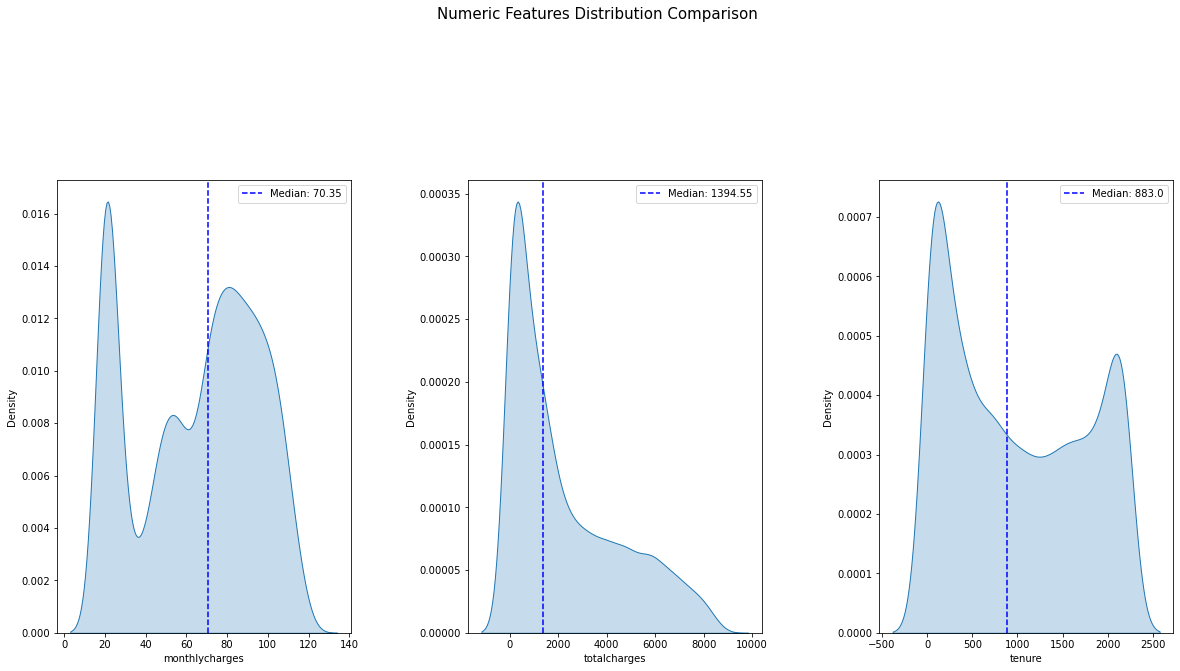

In [46]:
# Plotting a histogram for each numerical feature with its median
fig = plt.figure(figsize =(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.suptitle('Numeric Features Distribution Comparison', fontsize=15, y=1)
for i in range(1,len(num_col)+1):
    
    ax = fig.add_subplot(2, 3, i)
    sns.kdeplot(merged[num_col[i-1]], fill=True)
    plt.ylabel('Density', fontsize=10)
    
    plt.axvline(x=merged[num_col[i-1]].median(),
            color='blue',
            ls='--', 
            lw=1.5, 
            label = 'Median: {:}'.format(merged[num_col[i-1]].median()))
    plt.legend()

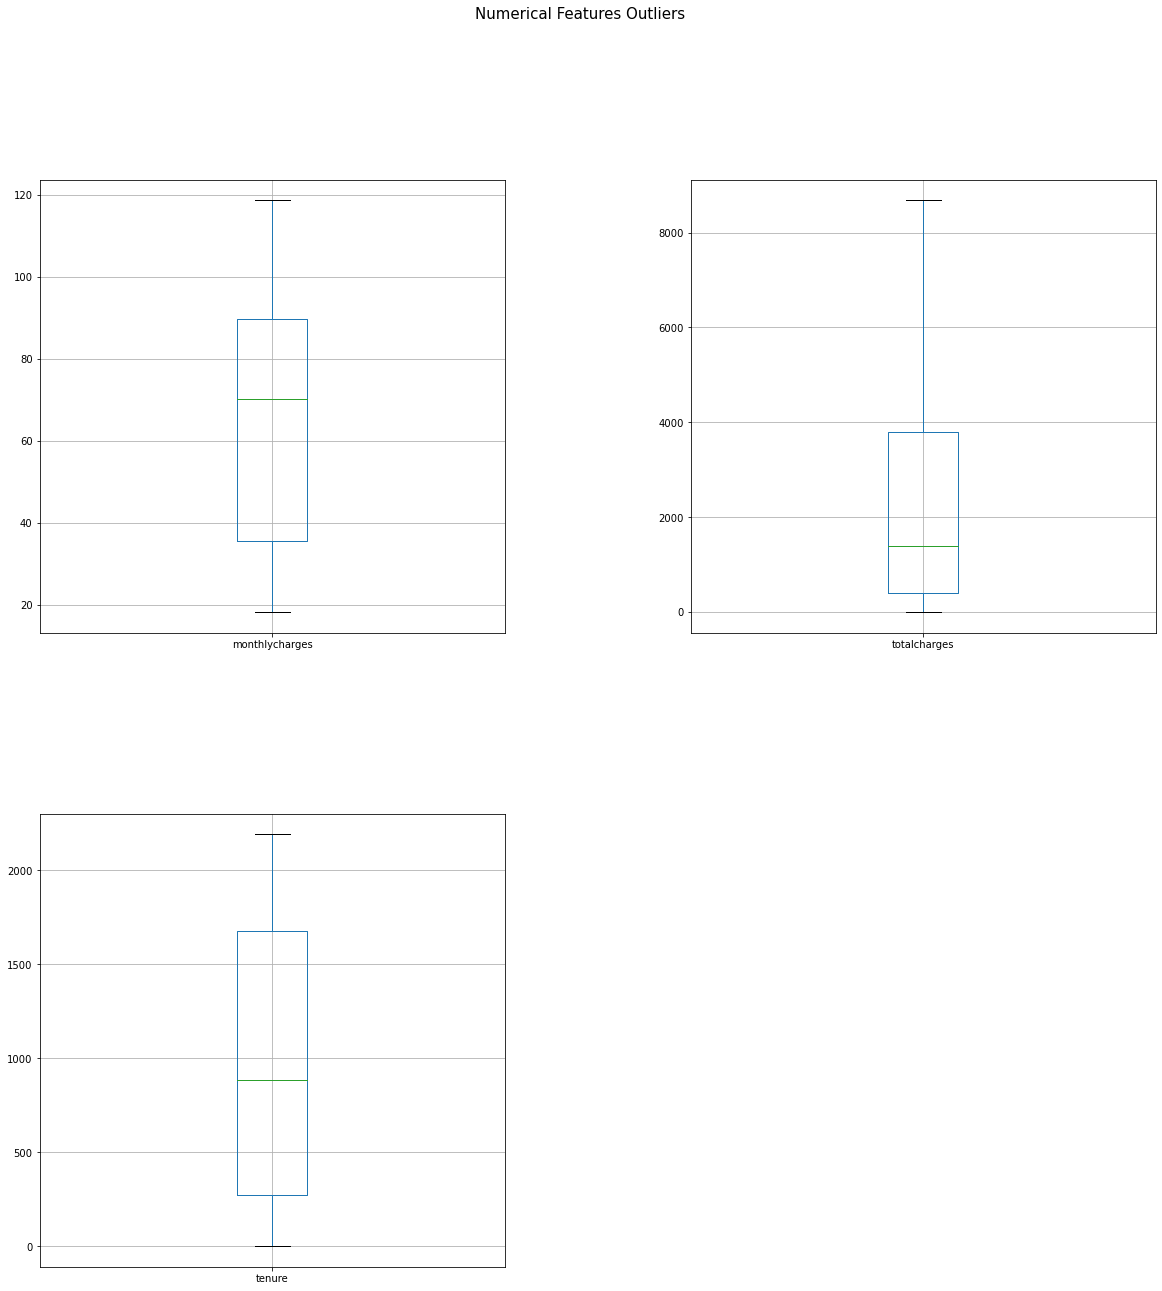

In [47]:
# Checking the outliers of the numerical variables
fig = plt.figure(figsize =(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Numerical Features Outliers', fontsize=15, y=1)
for i in range(1,len(num_col)+1):
    ax = fig.add_subplot(2, 2, i)
    merged.boxplot(num_col[i-1])
    Q1 = merged[num_col[i-1]].quantile(0.25)
    Q3 = merged[num_col[i-1]].quantile(0.75)

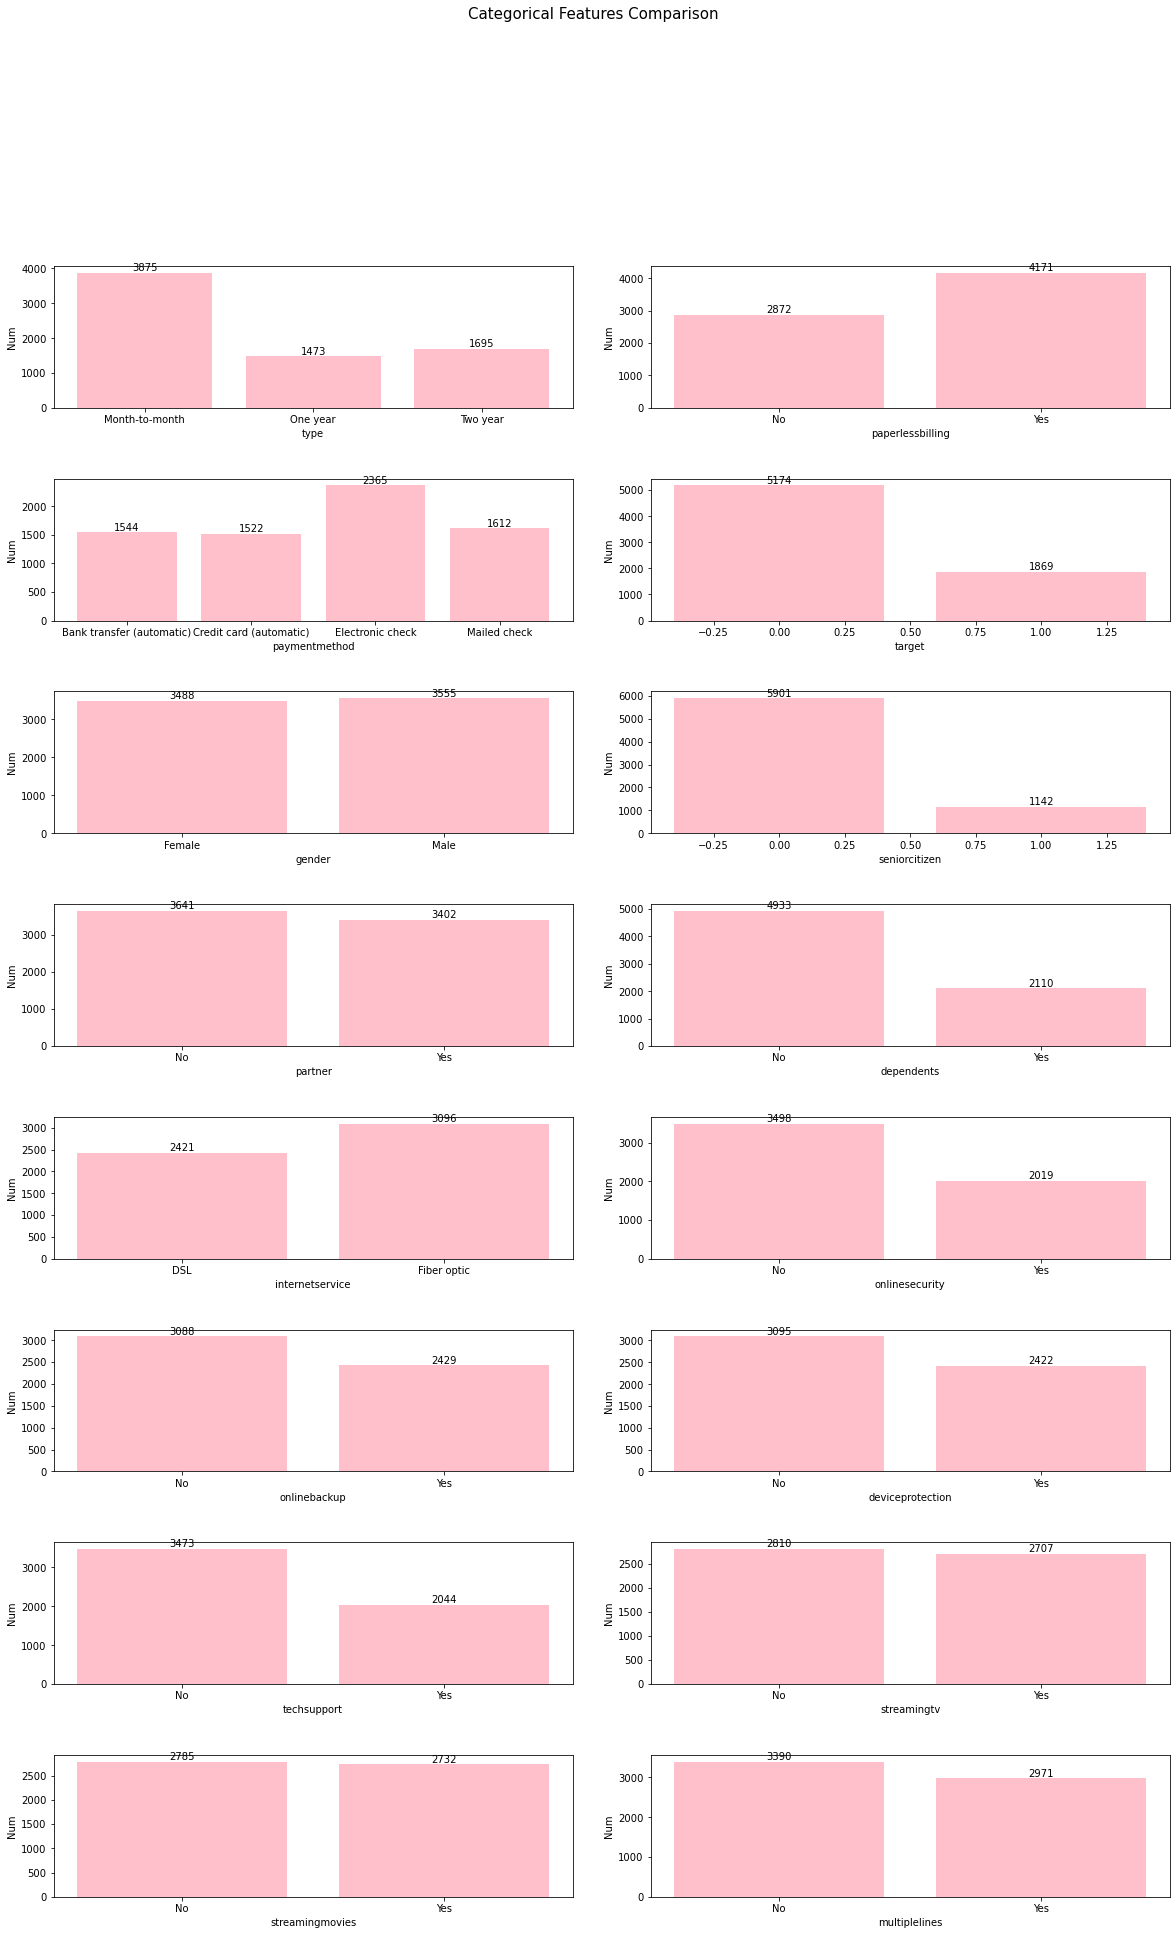

In [48]:
# Plotting a histogram for each categorical feature
fig = plt.figure(figsize =(20, 30))
fig.subplots_adjust(hspace=0.5, wspace= 0.15)
fig.suptitle('Categorical Features Comparison', fontsize=15, y=1)

for i in range(1,len(cat_col)+1):
    
    cat_grouped = merged.groupby(cat_col[i-1])['customerid'].nunique().reset_index()
    cat_grouped.columns = [cat_col[i-1], 'num']
    
    ax = fig.add_subplot(8, 2, i)
    plt.bar(cat_grouped[cat_col[i-1]],cat_grouped['num'], color = 'pink')
    plt.xlabel(cat_col[i-1])
    plt.ylabel('Num', fontsize=10)
    ax.bar_label(ax.containers[0], label_type='edge')

We no longer need the **customerid** column, because it basically like an index column and holds no information for our model. So, we will remove it from our data set.

In [49]:
merged = merged.drop('customerid', axis = 1)

### Conclusions

**Numerical features**
1. On average, each customer pays around 70.5 each month.  
2. In total, the charges that the company gets from each customer are about 1,394.55
3. The average time that a customer stays with the company is 883 days, which is 2.48 years. 

**Categorical features**
1. **contract type** - most people use the **month-to-month** plan rather than one-year or two years types. It seems that people don't like to be obligated for the long term. 
2. **billing type** - most of the customers don't use paper for the bill, but rather electronic means. The most popular billing method is **electronic check**.
3. **target variable** - the target variable is highly unbalanced, and we have a lot more users that didn't churn than users that churned (it is a good thing because if most of the users would have churned, then it would be profitable business). When we will train our models, we will balance the target variable in the **train set** to optimize the training process. 
4. **gender** - the 2 genders are equally balanced. 
5. **senior citizen** - most of the users are not senior citizens, which makes sense because most of the senior citizens don't use the internet and streaming services.
6. **partner** - the data here is balanced. 
7. **dependents** - most of the company users don't have dependents (maybe most of them don't have children).
8. **internet service** - most of the clients use the fibers instead of DSL - makes sense, it is much faster.
9. **online security, online backup, device protection, tech support** - most of the users don't purchase these services. 
10. **all the streaming services (tv and movies)** - these services are balanced among those who purchase them and those who don't.
11. **multiplelines** - most of the users don't purchase this service, although not much more than those who do. 

### Work Plan

1. Load the data
2. Merge and quick clean the data
3. Performe EDA on the data
4. Decide how to deal with the missing values. If filling them, then choose the best method to do so among the various techniques (KNN Imputer, constant, etc.)
5. Split the data to train, validation and test in a ratio of 60:20:20
6. Perform features engineering:
 - **numerical features:** scaling the data with the most suitable scaler (Standardscaler or MinMaxscaler, etc.)
 - **categorical features:** encoding the data with the most suitable encoding method (ordinal encoding, one hot encoding, etc.)
 - **target variable** - in the **train** set, balance the target varaible to optimize the training process.
7. Pick a baseline model 
8. Training different models to choose the one with the highest AUC-ROC score:
 - Logistic Regression
 - Decision Tree Classifier
 - Random Forest Classifier
 - lightGBM Classifier
 - CatBoost Classifier
9. Choosing the model with the best performance (the one with the highest AUC-ROC score) and applying it to the test set. 

### Missing Values

As we mentioned earlier, there are missing values in the merged data set. This occurs probably because some of the users don't use all the services that the company has - some customers use the internet but not the phone and vice versa. Having that said, we can say that these values aren't really missing (meaning there is no bug in the data or in the collection process of the data), but actually, they are values themselves - the value 'No'. Meaningly, a particular customer doesn't use an internet or phone service. 

So, in this stage, we will replace all the missing values with the value "No". 

In [50]:
merged = merged.fillna('No')

In [51]:
merged.stb.missing(style = True)

,missing,total,percent
type,0,"7,043",0.00%
dependents,0,"7,043",0.00%
streamingmovies,0,"7,043",0.00%
streamingtv,0,"7,043",0.00%
techsupport,0,"7,043",0.00%
deviceprotection,0,"7,043",0.00%
onlinebackup,0,"7,043",0.00%
onlinesecurity,0,"7,043",0.00%
internetservice,0,"7,043",0.00%
partner,0,"7,043",0.00%


Filling the missing values with the value "No" was successful.

### Splitting The Data (60 : 20 : 20)

Before dealing with the missing values and execution of the features engineering process, we will split the data to train, validation and test.  

In [52]:
# splitting the data to train, validation and test using the train_test_split function
train_temp, test = train_test_split(merged, test_size = 0.20, random_state = 12345, shuffle = True)
train, valid = train_test_split(train_temp, test_size = 0.25, random_state = 12345)

In [53]:
# saving the target varaible in a separate variable
target_train = train['target'].reset_index(drop = True)
target_valid = valid['target'].reset_index(drop = True)
target_test = test['target'].reset_index(drop = True)

### Scaling the numerical features using the MinMaxScaler

In [54]:
# setting a MinMax instance
scaler = MinMaxScaler()

# scaling the numerical features in both train and test data sets
train_scaled = pd.DataFrame(scaler.fit_transform(train[num_col].copy()),
                           columns = num_col).reset_index(drop = True)

valid_scaled = pd.DataFrame(scaler.transform(valid[num_col].copy()),
                           columns = num_col).reset_index(drop = True)

test_scaled = pd.DataFrame(scaler.transform(test[num_col].copy()),
                           columns = num_col).reset_index(drop = True)

In [55]:
train_scaled.head(3)

,monthlycharges,totalcharges,tenure
0,0.027861,0.061205,0.333181
1,0.627861,0.026909,0.041990
2,0.873632,0.869801,0.973072


In [56]:
valid_scaled.head(3)

,monthlycharges,totalcharges,tenure
0,0.404478,0.444121,0.903241
1,0.260697,0.009522,0.028298
2,0.514428,0.008054,0.014149


In [57]:
test_scaled.head(3)

,monthlycharges,totalcharges,tenure
0,0.011443,0.061003,0.375171
1,0.665174,0.215745,0.304884
2,0.531343,0.008250,0.013692


### Encoding the categorical features using the OrdinalEncoder

In [58]:
# initiate the encoder
encoder = OrdinalEncoder()

# building encoding function 
def encode (df_train, df_valid, df_test):
    
    # retaining only non-null values
    nonulls_train = np.array(df_train.dropna())
    nonulls_valid = np.array(df_valid.dropna())
    nonulls_test = np.array(df_test.dropna())
    
    # reshaping the data for encoding
    impute_reshape_train = nonulls_train.reshape(-1,1)
    impute_reshape_valid = nonulls_valid.reshape(-1,1)
    impute_reshape_test = nonulls_test.reshape(-1,1)
    
    # encoding the data
    impute_ordinal_train = encoder.fit_transform(impute_reshape_train)
    impute_ordinal_valid = encoder.transform(impute_reshape_valid)
    impute_ordinal_test = encoder.transform(impute_reshape_test)
    
    # assigning back encoded values instead of their non-encoded values
    df_train.loc[df_train.notnull()] = np.squeeze(impute_ordinal_train)
    df_valid.loc[df_valid.notnull()] = np.squeeze(impute_ordinal_valid)
    df_test.loc[df_test.notnull()] = np.squeeze(impute_ordinal_test)
    
    return df_train, df_valid, df_test

In [59]:
# removing the target variable from the categorical features list
cat_col.remove('target')

In [60]:
'target' in cat_col

False

In [61]:
# creating a loop to iterate over the categorical features in both data sets
for col in cat_col:
    encode(train[col], valid[col], test[col])

# assigning the encoded features to unique variables
train_encoded = train[cat_col].reset_index(drop = True)
valid_encoded = valid[cat_col].reset_index(drop = True)
test_encoded = test[cat_col].reset_index(drop = True)

In [62]:
train_encoded.head(3)

,type,paperlessbilling,paymentmethod,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [63]:
valid_encoded.head(3)

,type,paperlessbilling,paymentmethod,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
test_encoded.head(3)

,type,paperlessbilling,paymentmethod,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, after scaling the numerical features and encoding the categorical features, we will combine them to one data set.

In [65]:
# combining the numerical and categorical features into one train set
train_features = pd.concat([train_scaled, train_encoded], axis = 1).reset_index(drop = True)

# combining the numerical and categorical features into one validation set
valid_features = pd.concat([valid_scaled, valid_encoded], axis = 1).reset_index(drop = True)

# combining the numerical and categorical features into one test set
test_features = pd.concat([test_scaled, test_encoded], axis = 1).reset_index(drop = True)

In [66]:
train_features.head(3)

,monthlycharges,totalcharges,tenure,type,paperlessbilling,paymentmethod,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,0.027861,0.061205,0.333181,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.627861,0.026909,0.041990,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.873632,0.869801,0.973072,0.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [67]:
valid_features.head(3)

,monthlycharges,totalcharges,tenure,type,paperlessbilling,paymentmethod,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,0.404478,0.444121,0.903241,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.260697,0.009522,0.028298,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.514428,0.008054,0.014149,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
test_features.head(3)

,monthlycharges,totalcharges,tenure,type,paperlessbilling,paymentmethod,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,0.011443,0.061003,0.375171,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.665174,0.215745,0.304884,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.531343,0.008250,0.013692,0.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we will perform one more step of preprocessing on the numerical features. Because we are using gradient boosting models, we will need to convert the data type of the encoded categorical features from float to integers in order to optimize algorithms' performance. 

In [69]:
# setting a list with encoded categorical features
boost_cat_col = train_encoded.columns.to_list()

In [70]:
# creating a loop to convert the encoded categorical features from float to integer
for i in range(len(boost_cat_col)):
    train[boost_cat_col[i]] = train[boost_cat_col[i]].astype('int')
    valid[boost_cat_col[i]] = valid[boost_cat_col[i]].astype('int')
    test[boost_cat_col[i]] = test[boost_cat_col[i]].astype('int')

In [71]:
train.head(3)

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target,tenure,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
940,1,0,0,21.05,531.55,0,730,0,0,0,1,2,0,0,0,0,0,0,0
410,0,1,2,81.35,233.70,1,92,1,1,0,0,1,0,1,0,0,0,0,1
2079,0,1,2,106.05,7554.05,0,2132,1,0,1,1,1,1,1,0,0,1,1,1


In [72]:
valid.head(3)

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target,tenure,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
1857,2,0,1,58.90,3857.10,0,1979,0,0,1,0,0,1,0,1,1,0,0,0
3048,0,0,2,44.45,82.70,0,62,0,0,0,0,0,0,0,0,0,0,0,0
3969,0,1,1,69.95,69.95,0,31,1,0,1,1,1,0,0,0,0,0,0,0


In [73]:
test.head(3)

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target,tenure,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
1128,0,1,2,19.40,529.80,0,822,1,0,0,0,2,0,0,0,0,0,0,0
2875,0,1,2,85.10,1873.70,1,668,1,0,1,0,1,0,0,0,0,0,1,1
1783,0,1,2,71.65,71.65,1,30,1,0,0,1,1,0,0,0,0,0,0,0


### Balance The target Variable using Upsampling Technique

As we mentioned in the EDA chapter, the target variable is heavily unbalanced. This can negatively affect our model training, therefore we will use the upsampling balance technique to overcome this issue. We will upsample the target variable only in the train set, to maintain the test set as faithful to the real data as possible.

In [74]:
# setting the target and features variables for the train set
features_train = train.drop('target', axis = 1)
target_train = train['target']

# setting the target and features variables for the validation set
features_valid = valid.drop('target', axis = 1)
target_valid = valid['target']

# setting the target and features variables for the test set
features_test = test.drop('target', axis = 1)
target_test = test['target']

In [75]:
# building upsample function
def upsample (features, target):
    
    features_zero = features[target == 0]
    features_one = features[target == 1]
    target_zero = target[target == 0]
    target_one = target[target==1]
    
    repeat = round(len(target_zero) / len(target_one) )
    
    features_upsampled = pd.concat([features_zero] + [features_one]*repeat)
    target_upsampled = pd.concat([target_zero] + [target_one]*repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 12345)
    
    return features_upsampled, target_upsampled

In [76]:
# upsampling the target variable (and also the features) in the train set
features_train, target_train = upsample(features_train, target_train)

In [77]:
target_train.value_counts() / len(target_train)

1    0.52485
0    0.47515
Name: target, dtype: float64

In this chapter we conducted the following steps:
1. **Splitting the data** - we split the merged data set to train, validation and test sets. 
2. **Scaling the numerical features** - we scaled all the numerical features to make sure that all the numerical features will have the same weight.
3. **Encoding the categorical features** - we encoded all the categorical features using the MinMaxScaler. 
4. **Filling in missing values** - we filled in the missing values with the value "No". 
5. **Balancing the target variable** - we used the upsampling balancing technique to balance the target variable in the train set which was highly unbalanced. 


Now our data is ready for model training and testing. 

### Model Training

In [78]:
# setting an empty list for AUC-ROC metric
auc_list = []

**Model 0 - Baseline model - 'Dummy' Model**

This will be our baseline model that all the other models will be compared to it. 

In [79]:
# initializing the DummyClassifier algorithm
dummy = DummyClassifier(random_state = 12345)

# trainig the DummyCalssifier algorithm
dummy.fit(features_train, target_train)

# predicting the target variable
pred_dummy = dummy.predict(features_valid)

# calculating the positive class probability
proba_dummy = dummy.predict_proba(features_valid)
proba_one_dummy = proba_dummy[:, 1]

# calculating the AUC-ROC metric
roc_auc_dummy = roc_auc_score(target_valid, proba_one_dummy)
auc_list.append(round(roc_auc_dummy,2))

# printing the AUC-ROC of the dummy algorithm
print('The AUC-ROC of the Dummy Calssifier algorithm is: {:.2}'.format(roc_auc_dummy))

The AUC-ROC of the Dummy Calssifier algorithm is: 0.5


**Model 1 - Logictic Regression**

In [80]:
# initializing the Logistic Regression algorithm
lr = LogisticRegression(random_state = 12345, solver = 'liblinear')

# training the Logistic Regression algorithm
lr.fit(features_train, target_train)

# predicting the target variable
pred_lr = lr.predict(features_valid)

# calculating the positive class probability
proba_lr = lr.predict_proba(features_valid)
proba_one_lr = proba_lr[:, 1]

# calculating the AUC-ROC metric
roc_auc_lr = roc_auc_score(target_valid, proba_one_lr)
auc_list.append(round(roc_auc_lr,2))

# printing the AUC-ROC of the Logistic Regression algorithm
print('The AUC-ROC of the Logistic Regression algorithm is: {:.2}'.format(roc_auc_lr))

The AUC-ROC of the Logistic Regression algorithm is: 0.82


**Model 2 - Decision Tree Classifier**

In [81]:
# Creating an objective function to train and evaluate the model
def objective_tree(trial):
    
    # hyperparameter setting
    max_depth = trial.suggest_int('max_depth', 5, features_train.shape[1])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    min_impurity_decrease = trial.suggest_uniform('min_impurity_decrease', 0.01, 0.2)
    
    # model training and evaluation
    model = DecisionTreeClassifier(
            max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
    min_impurity_decrease = min_impurity_decrease, random_state = 12345)
    
    model.fit(features_train, target_train)
    
    proba = model.predict_proba(features_valid)
    proba_one = proba[:, 1]
    
    auc_roc = roc_auc_score(target_valid, proba_one)

    # output: evaluations score
    return auc_roc

In [82]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective_tree, n_trials = 100)

tree_best_params = study.best_params
auc_list.append(round(study.best_value, 2))

print('Maximum AUC-ROC: ', study.best_value)
print('Best parameter: ', study.best_params)

Maximum AUC-ROC:  0.7986267598077088
Best parameter:  {'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.010887097277851716}
CPU times: user 1.93 s, sys: 280 ms, total: 2.21 s
Wall time: 1.28 s


**Model 3 - Random Forest Classifier**

In [83]:
# Creating an objective function to train and evaluate the model
def objective_forest(trial):
    
    # hyperparameter setting
    max_depth = trial.suggest_int('max_depth', 4, 50)
    min_impurity_decrease = trial.suggest_uniform('min_impurity_decrease',0.01, 0.2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 6)
    
    # model training and evaluation
    model = RandomForestClassifier(
            max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
    min_impurity_decrease = min_impurity_decrease, random_state = 12345)
    
    model.fit(features_train, target_train)
    
    proba = model.predict_proba(features_valid)
    proba_one = proba[:, 1]
    
    auc_roc = roc_auc_score(target_valid, proba_one)

    # output: evaluations score
    return auc_roc

In [84]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective_forest, n_trials = 100)

forest_best_params = study.best_params
auc_list.append(round(study.best_value, 2))

print('Maximum AUC-ROC: ', study.best_value)
print('Best parameter: ', study.best_params)

Maximum AUC-ROC:  0.8252760430079835
Best parameter:  {'max_depth': 31, 'min_impurity_decrease': 0.010030706044810819, 'min_samples_split': 9, 'min_samples_leaf': 4}
CPU times: user 17.5 s, sys: 63.7 ms, total: 17.6 s
Wall time: 17.6 s


**Model 4 - LightGBM Classifier**

In [85]:
# Creating an objective function to train and evaluate the model
def objective_lgbm(trial):
    
    # hyperparameter setting
    max_depth = trial.suggest_int('max_depth', 4, 50)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_uniform('learning_rate',0.01, 1)
    min_split_gain = trial.suggest_int('min_split_gain', 2, 20)
    
    # model training and evaluation
    model = lgb.LGBMClassifier(
        max_depth=max_depth, n_estimators = n_estimators, 
                                  learning_rate = learning_rate, min_split_gain = min_split_gain,
                                 random_state = 12345)
    
    model.fit(features_train, target_train)
    
    proba = model.predict_proba(features_valid)
    proba_one = proba[:, 1]
    
    auc_roc = roc_auc_score(target_valid, proba_one)

    # output: evaluations score
    return auc_roc

In [86]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective_lgbm, n_trials = 100)

lgbm_best_params = study.best_params
auc_list.append(round(study.best_value, 2))

print('Maximum AUC-ROC: ', study.best_value)
print('Best parameter: ', study.best_params)

Maximum AUC-ROC:  0.8922117778350074
Best parameter:  {'max_depth': 12, 'n_estimators': 195, 'learning_rate': 0.6143208414198025, 'min_split_gain': 5}
CPU times: user 32.3 s, sys: 3.49 s, total: 35.8 s
Wall time: 4.65 s


**Model 5 - CatBoost Classifier**

In [87]:
# Creating an objective function to train and evaluate the model
def objective_cat(trial):
    
    # hyperparameter setting
    max_depth = trial.suggest_int('max_depth', 4, 16)
    n_estimators = trial.suggest_int('n_estimators', 150, 200)
    
    # model training and evaluation
    model = CatBoostClassifier(max_depth=max_depth, n_estimators = n_estimators,  
                                 random_state = 12345, verbose = 0)
    
    model.fit(features_train, target_train)
    
    proba = model.predict_proba(features_valid)
    proba_one = proba[:, 1]
    
    auc_roc = roc_auc_score(target_valid, proba_one)

    # output: evaluations score
    return auc_roc

In [88]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective_cat, n_trials = 10)

cat_best_params = study.best_params
auc_list.append(round(study.best_value, 2))

print('Maximum AUC-ROC: ', study.best_value)
print('Best parameter: ', study.best_params)

Maximum AUC-ROC:  0.8645082195896644
Best parameter:  {'max_depth': 4, 'n_estimators': 174}
CPU times: user 1min 26s, sys: 3.7 s, total: 1min 29s
Wall time: 49 s


In [89]:
# creating a list with all models' names to be used as index
model_name = ['Dummy Model', 'Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier',
             'LightGBM Classifier', 'CatBoost Classifier']

# creating a dictionary with the AUC-ROC metric of all models
auc_dic = {'AUC-ROC': auc_list}

# creating DataFrame that summarize the results of all models 
df_model_scores = pd.DataFrame(auc_dic, index = model_name).sort_values(by = 'AUC-ROC', ascending = False)
df_model_scores

,AUC-ROC
LightGBM Classifier,0.89
CatBoost Classifier,0.86
Random Forest Classifier,0.83
Logistic Regression,0.82
Decision Tree Classifier,0.80
Dummy Model,0.50


### Testing The Best Model

In [90]:
# initiate the LightGBM Classifier with it's best hyperparameters
lgbm_best_model = lgb.LGBMClassifier(max_depth = lgbm_best_params['max_depth'], 
                                   n_estimators = lgbm_best_params['n_estimators'], 
                                    learning_rate = lgbm_best_params['learning_rate'],
                                    min_split_gain = lgbm_best_params['min_split_gain'],
                                   random_state = 12345)

# training the regressor
lgbm_best_model.fit(features_train, target_train)

# calculating the positive class probability
proba = lgbm_best_model.predict_proba(features_test)
proba_one = proba[:, 1]
 
# calculating the AUC-ROC metric
auc_roc = roc_auc_score(target_test, proba_one)

# printing the AUC-ROC metric
print('The AUC-ROC metric for best LightGBM Classifier using the test set: {:.2}'.format(auc_roc))

The AUC-ROC metric for best LightGBM Classifier using the test set: 0.89


### Summary

In this chapter we trained 6 different models, one is a baseline model, and the others are 'regular' classification models. The 'regular' models that we used are:
1. Logistic Regression 
2. Decision Tree Classifier
3. Random Forest Classifier
4. LightGBM Classifier
5. CatBosst Classifier

We managed to train one model that have a higher score than 0.88:

**LightGBM Classifier** - gained the highest **AUC-ROC score of 0.89**

### Solution Report

**The Task**

A telecom company that provides several services would like to predict whether a customer is going to churn or not in order to preserve clients. If it’s found that a client is about to churn, special benefits will be offered to him in order to prevent him from leaving the company.


The company provided 4 data sets that contained different information about the company's clients, according which we were supposed to give the predictions:

1. **Contract** - a data set that contains information about the contract of the users.
2. **Personal** - a data set that contains personal information of the clients.
3. **Internet** - a data set that contains the information of the clients that use the internet services that the company provides.
4. **Phone** - the same as the Internet data set, just regarding phone service. 

**The procedure**
1. **Load the data**

The first step was to load the data and have a quick look at it. 


2. **Quick Cleaning**

After loading the data, we did a quick clean of the data. We lowercased the column names converted for some variables their data type to the right one and etc. 


3. **Target leakage**

To prevent data leakage to the target variable, I created the ‘tenure’ variable and calculated its values using the ‘enddate’ and ‘begindate’ features. To calculate the ‘tenure’ feature values, I replaced the values of paying customers (customers who didn’t churn and continue to use the company services) in the ‘enddate’ from ‘Not’ to the date when the data was collected - 1.2.2020. From that point the calculation was easy. Then the final step after calculating the ‘tenure’ feature, was removing both the ‘enddate’ and ‘begindate’ features - this will prevent data leakage to the target variable.  

4. **Merging All Data Sets**

The next step after creating the ‘tenure’ variable was merging the 4 data sets into one united set. All the data sets have a common feature - ‘customerid’ and we used it to combine the data sets.

5. **EDA**

After merging all datasets, we conducted EDA in order to better understand or data. The most important thing that we noticed is that the target variable suffers from high imbalance. This needs to be cared later on in the features engineering step.

6. **Filling missing value**

After combining all data sets, we discovered that the new merged data set contained 31.25% missing values. After a short examination, we found out that the reason for it is that some users don’t use all the services that the company provides - for example, some clients use the phone services but don't use the internet services and vice versa. 

These missing values aren’t really missing, because they don’t appear due to a bug in the data or in the data collection process, but rather because the customers really don’t use these services. That is that these missing values are values themselves, so **I decided to fill them in with the value ‘No’**. 

7. **Splitting The Data Set**

After filling in the missing values, we splited the merged dataset into 3 different data sets (with a ratio of 60: 20: 20) :
- train - 60%
- validation - 20%
- test - 20% 

8. **Features Engineering**

After filling in the missing data we turned to Features engineering. The data set contains both numerical and categorical features, so each kind needs to be treated differently. We will also take care of the target variable and correct its imbalance using balance technique.

- **Scaling the numerical features**

It is important to scale the numerical features to make sure that all the features will have the same weight. This way our model won't think that one feature is more important than another feature. In this project, I chose to use the **MinMaxScaler** since it preserves the original distribution of the data and least disruptive to the information in the original data set.

- **Encoding the categorical features**

Since computers, and as result also ML models cant understand text but only numbers, we need to encode the categorical features and convert them to numbers. In this project, I chose the **OrdinalEncoder** since we have many features and I didn’t want to overload the algorithm with more features like this happens when using OHE (it creates many new features).

- **Balance the target variable**

It is important that the target variable values will be balanced for the training step of the models, otherwise the learning procedure will be poor. There are several ways of balancing the target variable, when the one that I chose is the **upsampling technique**, which takes the value that appears the least, and multiplies it until its amount is equal to the frequent values. 

9. **Model Training**

In this step, we trained 6 different models when one was a baseline model. The training and the hyperparameters tuning were made with **optuna library**, and the evaluation of the model in the training stage was made on the validation data set. The AUC-ROC scores of the models:
- LightGBM - 0.89
- CatBoost - 0.86
- Random Forest - 0.83
- Logistic Regression - 0.82
- Decision Tree - 0.8
- Dummy model - 0.5

10. **Model testing**

In the final stage, we chose the LightGBM model to test in on the test set, since it had the highest AUC-ROC score. **The AUC-ROC score for the best LightGBM model using the test set was 0.89**. This is a great score and above 0.88 which is the high bar of success, so in general, we can say that our model performs well. 

In the end, we can say that the **key steps** was training different models. The gradient boosting models had the best results, and that is the main step that boosted the quality of the predictions.  